In [63]:
# ============================================================
# PRIMERA CELDA - Cargar RAW DATA para clustering no supervisado
# ============================================================

import os
import pandas as pd

# Mostrar carpeta de trabajo
print("cwd:", os.getcwd())

# ----------------------------------------
# Opción A: dataset RAW completo
# ----------------------------------------
path_raw = "../../data/raw/star_classification.csv"

# ----------------------------------------
# Opción B: dataset 70% que tú generaste
# ----------------------------------------
path_70 = "../../data/clustering/star_classification_70.csv"

# ----------------------------------------
# Seleccionar UNA de las dos
# ----------------------------------------
DATASET_PATH = path_70   # <-- Usa este si quieres el 70% (recomendado)

# Cargar dataset
df = pd.read_csv(DATASET_PATH)

print("\nDataset cargado desde:", DATASET_PATH)
print("Filas x Columnas:", df.shape)
print("\nColumnas:")
print(df.columns)


cwd: C:\Users\diego\Documents\python\data_mining_homework\REPOS\stellar_classification_dataset\03_clustering\notebooks

Dataset cargado desde: ../../data/clustering/star_classification_70.csv
Filas x Columnas: (70000, 18)

Columnas:
Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'redshift', 'plate',
       'MJD', 'fiber_ID', 'class'],
      dtype='object')


In [64]:
# ============================================================
# SEGUNDA CELDA - Preprocesamiento para clustering
# ============================================================

import pandas as pd
from sklearn.preprocessing import StandardScaler

# ----------------------------------------
# 1. Quitar columnas supervisadas
# ----------------------------------------
cols_drop = ["class", "redshift","run_ID","rerun_ID","cam_col","field_ID","spec_obj_ID","plate","MJD","fiber_ID","alpha","delta","obj_ID"]
df_unsup = df.drop(columns=cols_drop, errors="ignore")

print("Columnas eliminadas (si existían):", cols_drop)
print("Shape después del drop:", df_unsup.shape)

# ----------------------------------------
# 2. Conservar solo características numéricas
# ----------------------------------------
df_unsup = df_unsup.select_dtypes(include=["float64", "int64"])

print("Shape solo numéricas:", df_unsup.shape)

# ----------------------------------------
# 3. Escalar datos
# ----------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_unsup)

print("Datos escalados correctamente.")


Columnas eliminadas (si existían): ['class', 'redshift', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID', 'alpha', 'delta', 'obj_ID']
Shape después del drop: (70000, 5)
Shape solo numéricas: (70000, 5)
Datos escalados correctamente.


In [65]:
# ============================================================
# TERCERA CELDA - PCA no supervisado
# ============================================================

from sklearn.decomposition import PCA

# PCA reteniendo el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("PCA completado.")
print("Shape PCA:", X_pca.shape)
print("Varianza explicada acumulada:", pca.explained_variance_ratio_.sum())


PCA completado.
Shape PCA: (70000, 2)
Varianza explicada acumulada: 0.974147762002527


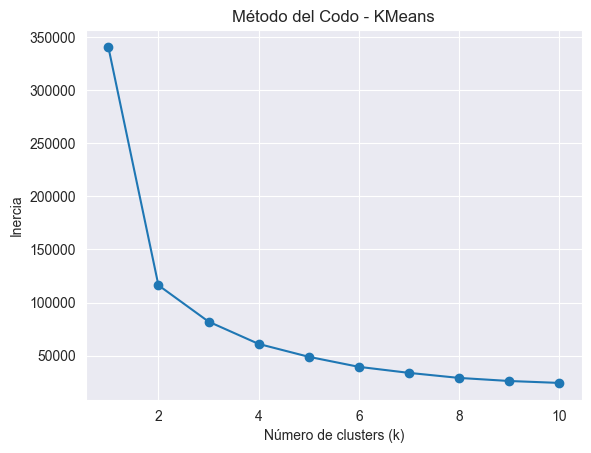

In [66]:
# ============================================================
# CUARTA CELDA - Método del Codo
# ============================================================

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo - KMeans")
plt.show()


In [67]:
# ============================================================
# QUINTA CELDA - Entrenar modelo final
# ============================================================

k_optimo = 3  # Puedes ajustarlo según el codo

kmeans = KMeans(n_clusters=k_optimo, random_state=42)
clusters = kmeans.fit_predict(X_pca)

print("K-Means entrenado con k =", k_optimo)


K-Means entrenado con k = 3


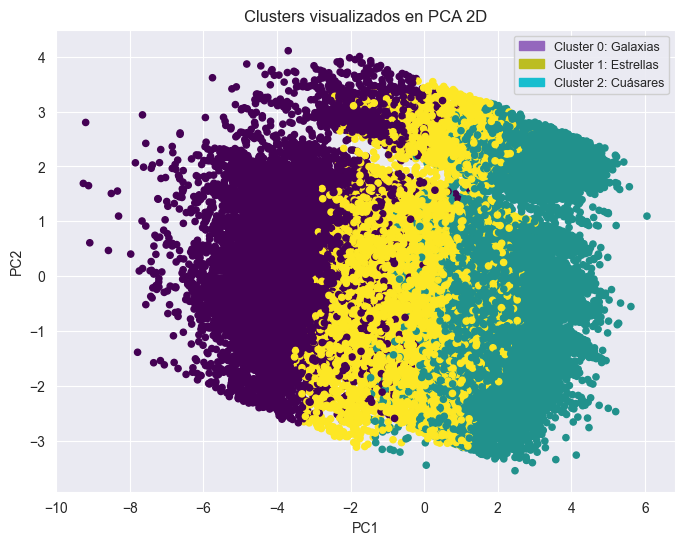

In [68]:
import matplotlib.patches as mpatches

# Colores usados por el scatter
# (Puedes ajustarlos si estás usando otro colormap)
cluster_colors = {
    0: "tab:purple",   # Cluster 0
    1: "tab:olive",    # Cluster 1
    2: "tab:cyan"      # Cluster 2
}

# Leyendas interpretativas
legend_labels = {
    0: "Cluster 0: Galaxias",
    1: "Cluster 1: Estrellas",
    2: "Cluster 2: Cuásares"
}

# Crear elementos para la leyenda
legend_patches = [
    mpatches.Patch(color=cluster_colors[i], label=legend_labels[i])
    for i in cluster_colors
]

# === PLOTEO ===
plt.figure(figsize=(8,6))
plt.scatter(components_vis[:,0], components_vis[:,1], c=clusters, cmap='viridis', s=20)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters visualizados en PCA 2D")

# Agregar leyenda explicada
plt.legend(handles=legend_patches, fontsize=9, loc="upper right", framealpha=0.9)

plt.show()


In [69]:
# ============================================================
# SÉPTIMA CELDA - Guardar resultados
# ============================================================

df_out = df.copy()
df_out["cluster"] = clusters

df_out.to_csv("kmeans_clusters.csv", index=False)

print("Archivo guardado con éxito.")


Archivo guardado con éxito.


In [70]:
import joblib
import json

# Guardar scaler, pca y kmeans
joblib.dump(scaler, "scaler_clust.pkl")
joblib.dump(pca, "pca_clust.pkl")
joblib.dump(kmeans, "kmeans_clust.pkl")

# Guardar columnas del dataset usado para entrenar
with open("columns_clust.json", "w") as f:
    json.dump({"columns": df_unsup.columns.tolist()}, f)

print("Modelos de clustering guardados.")


Modelos de clustering guardados.
